In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import pymc3
import emcee
import chainconsumer
import matplotlib as mpl

import config
import parameter_estimation_anthropic

In [2]:
filename = "anthropic_parameter1.npz"
df = np.load(config.data_path + "/" + filename)
samples = df["samples"].reshape((-1, parameter_estimation_anthropic.ndim))

#drop = samples.shape[0] // 1
#samples = samples[drop:, :]

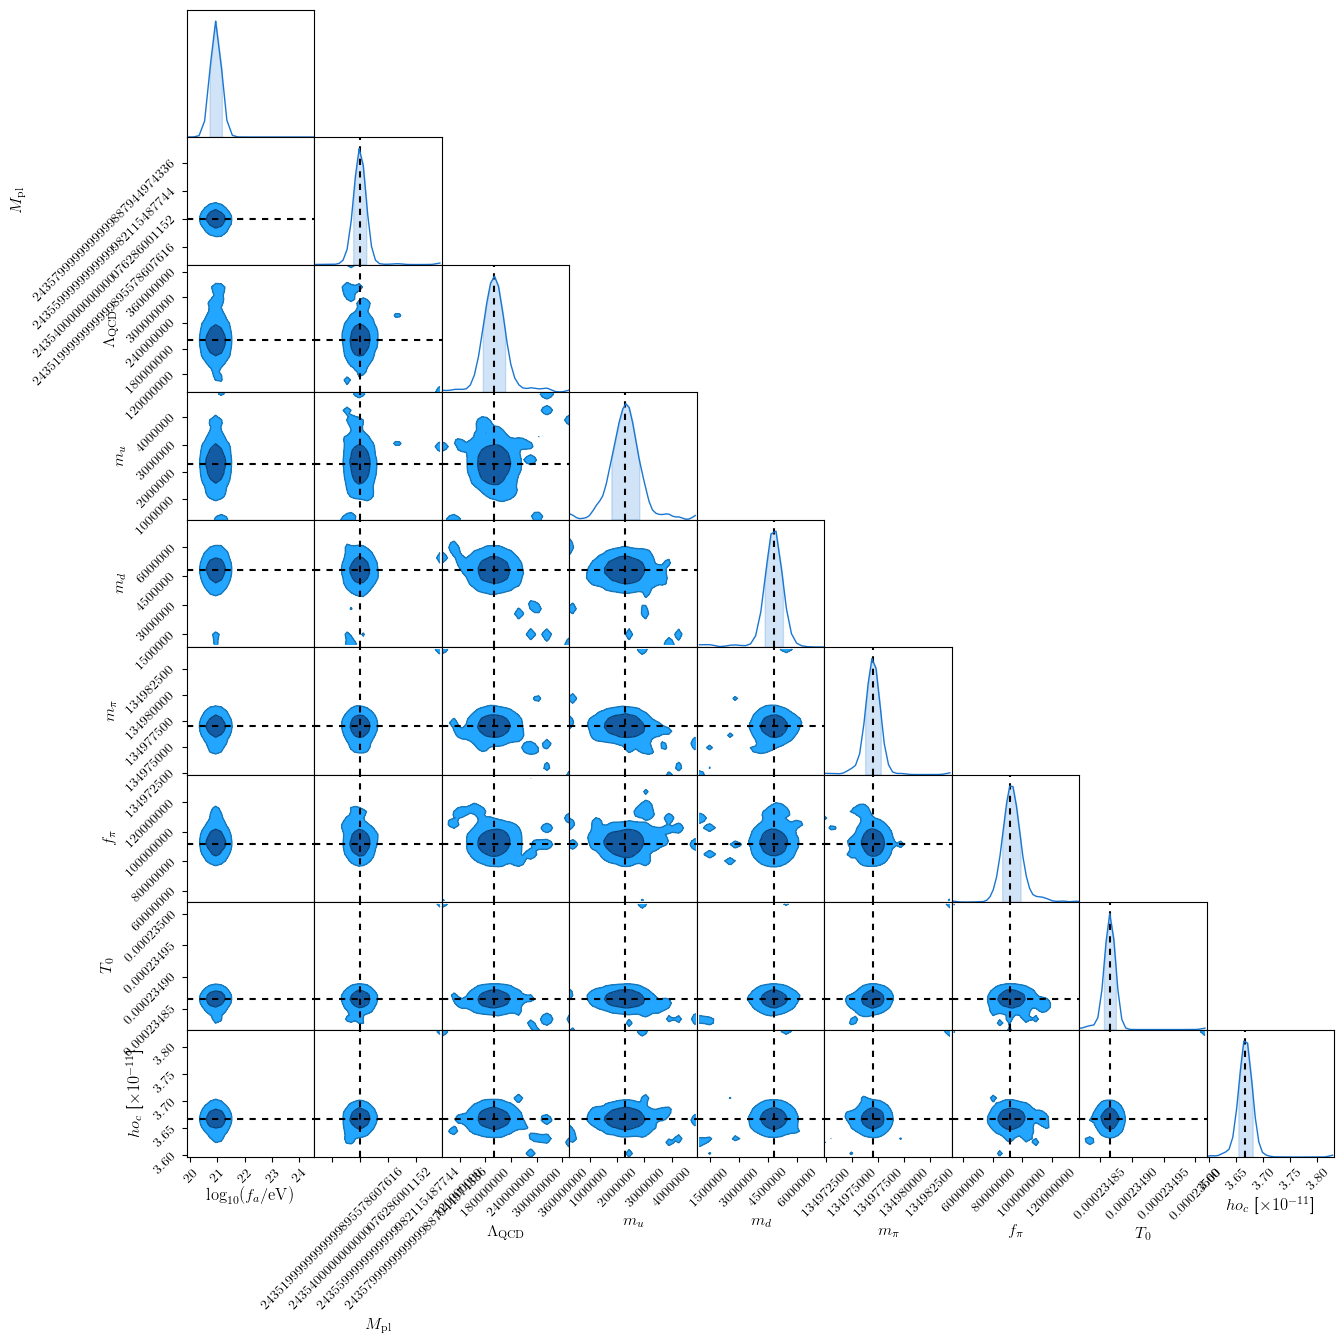

In [12]:
names = [
 '$\log_{10} (f_a / \mathrm{eV})$',
 '$M_\mathrm{pl}$',
 '$\Lambda_\mathrm{QCD}$',
 '$m_u$',
 '$m_d$',
 '$m_\pi$',
 '$f_\pi$',
 '$T_0$',
 '$\rho_c$',
]
c = chainconsumer.ChainConsumer()
c.add_chain(samples, parameters=names)
c.configure(smooth=True, plot_point=True, bins=20)
c.plotter.plot(display=False,
             truth={name: parameter_estimation_anthropic.mean_values[i] for i, name in enumerate(names)
                   if i not in [0]},              
)
mpl.rcParams.update(mpl.rcParamsDefault)

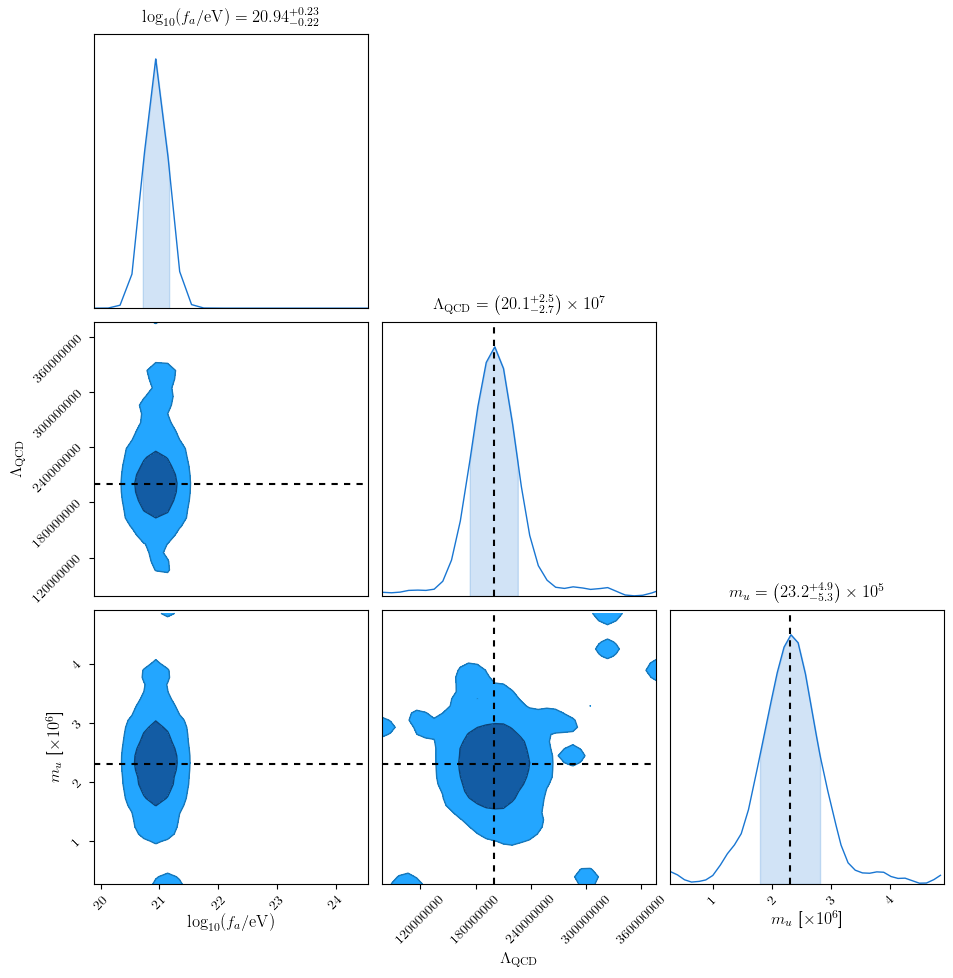

In [13]:
names = [
 '$\log_{10} (f_a / \mathrm{eV})$',
 '$M_\mathrm{pl}$',
 '$\Lambda_\mathrm{QCD}$',
 '$m_u$',
 '$m_d$',
 '$m_\pi$',
 '$f_\pi$',
 '$T_0$',
 '$\rho_c$',
]
c = chainconsumer.ChainConsumer()
c.add_chain(samples, parameters=names)
c.configure(smooth=True, plot_point=True, bins=20)
c.plotter.plot(filename=config.plot_path + "/qcd_fixed_theta_triangle_plot.pdf", display=False,
             parameters=[
                 r'$\log_{10} (f_a / \mathrm{eV})$',
                 r'$\Lambda_\mathrm{QCD}$',
                 '$m_u$'],
             truth={r'$\Lambda_\mathrm{QCD}$': parameter_estimation_anthropic.mean_values[2], 
                    '$m_u$': parameter_estimation_anthropic.mean_values[3]},
            figsize="PAGE",              
)
mpl.rcParams.update(mpl.rcParamsDefault)

PARAMETER  INITIAL-VALUE    INITIAL-ERROR   MCMC-MEAN      +MCMC-ERR      -MCMC-ERR
log_f_a    1.700000e+01 +/- -1.000000e+00 vs 2.096809e+01 + 2.721926e-02 - 2.762766e-02
M_pl       2.435403e+27 +/- 2.792596e+22 vs 2.435399e+27 + 3.257232e+22 - 3.076437e+22
Lambda_QCD 2.000000e+08 +/- 2.000000e+07 vs 2.008393e+08 + 2.389583e+07 - 2.351899e+07
m_u        2.300000e+06 +/- 3.750000e+05 vs 2.336458e+06 + 4.932075e+05 - 5.057990e+05
m_d        4.800000e+06 +/- 3.250000e+05 vs 4.795077e+06 + 3.447455e+05 - 3.703997e+05
m_pi       1.349770e+08 +/- 5.000000e+02 vs 1.349770e+08 + 5.438287e+02 - 5.765061e+02
f_pi       9.192388e+07 +/- 5.000000e+06 vs 9.284628e+07 + 6.002128e+06 - 5.490304e+06
T0         2.348653e-04 +/- 5.170398e-09 vs 2.348648e-04 + 5.742797e-09 - 5.822666e-09
rho_c      3.667106e-11 +/- 9.808371e-14 vs 3.666827e-11 + 1.038059e-13 - 1.075176e-13


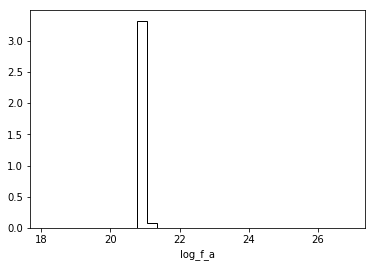

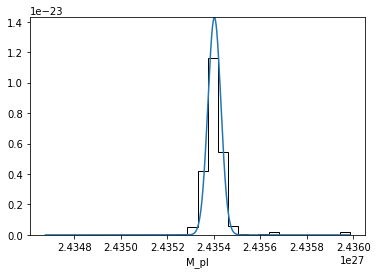

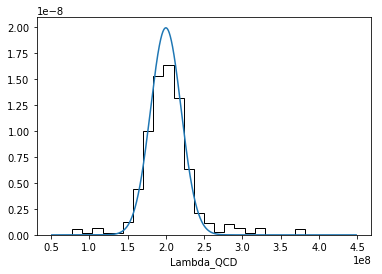

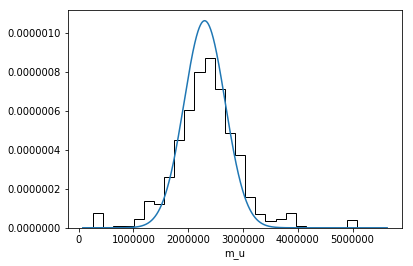

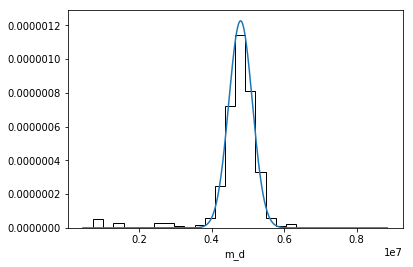

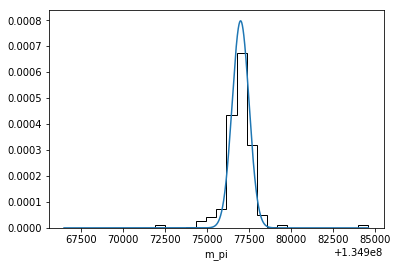

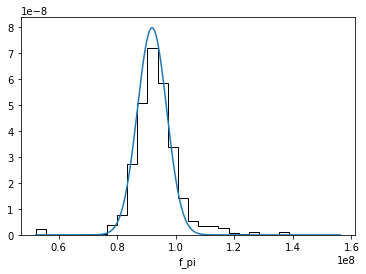

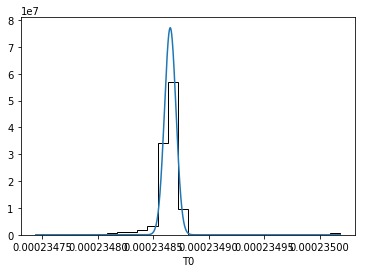

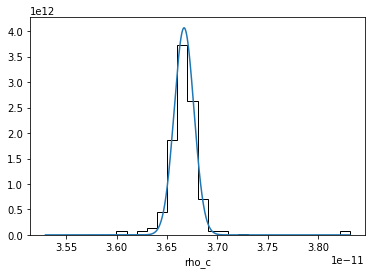

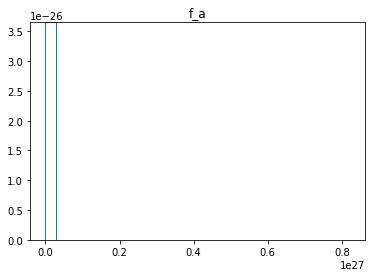

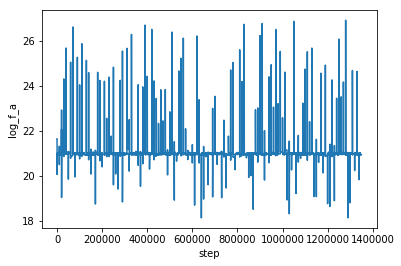

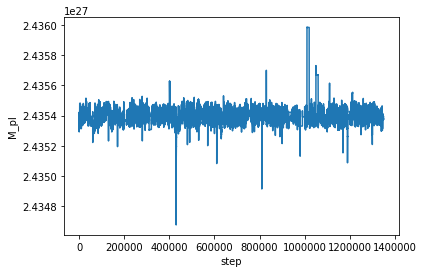

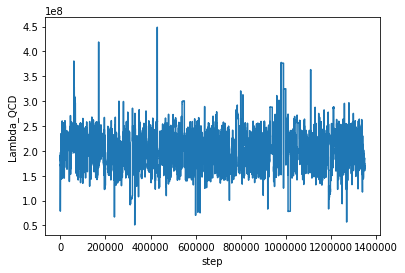

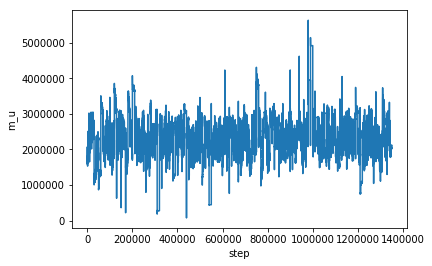

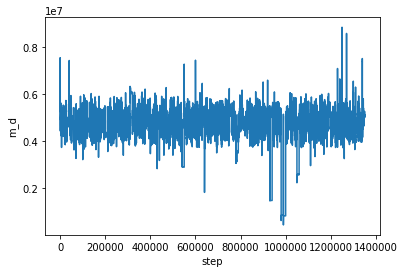

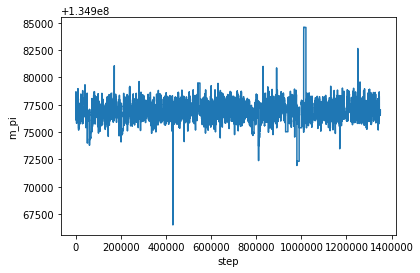

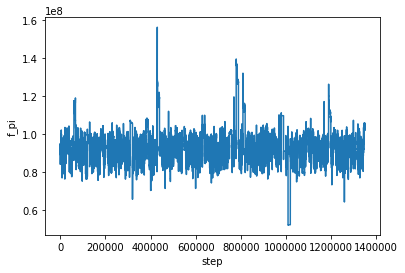

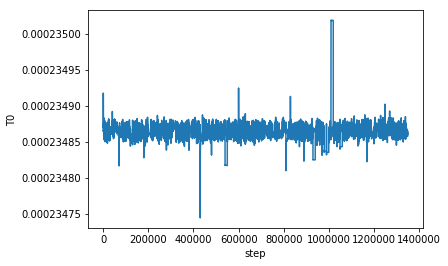

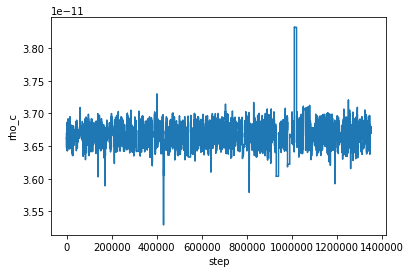

In [5]:


# compute parameter including error bounds
if "parameter" in df:
    parameter = df["parameter"]
else:
    #                          mean value, lower error, upper error
    parameter = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

# print table of parameters
print("PARAMETER  INITIAL-VALUE    INITIAL-ERROR   MCMC-MEAN      +MCMC-ERR      -MCMC-ERR")
for name, ip, ie, p in zip(parameter_estimation_anthropic.parameter_names, 
                           parameter_estimation_anthropic.mean_values, 
                           parameter_estimation_anthropic.errors, parameter):
    print(name + " " * (len("Lambda_QCD") - len(name)), 
          "%e" % ip, "+/-", "%e" % ie, "vs", "%e" % p[0], "+", "%e" % p[1], "-", "%e" % p[2])

# histograms for each parameter including priors
for i, (name, x0, x_err) in enumerate(zip(parameter_estimation_anthropic.parameter_names,
                                          parameter_estimation_anthropic.mean_values, 
                                          parameter_estimation_anthropic.errors)):
    ps = samples[:, i]
    if i >= 1:
        vals = np.linspace(np.min(ps), np.max(ps), ps.size*4)
        plt.plot(vals, np.exp(- (vals - x0)**2 / (2 * x_err**2)) / np.sqrt(2 * np.pi * x_err**2))
    try:
        plt.hist(ps, histtype="step", bins=30, density=True, color="black")
    except Exception as e:
        print(name, "doesnt work")
        print(e)
    plt.xlabel(name)
    plt.show()

f_a = 10**samples[:, 0]
plt.hist(f_a, bins=30, density=True, histtype="step")
plt.title("f_a")
plt.show()

# samples 
for i, name in enumerate(parameter_estimation_anthropic.parameter_names):
    plt.plot(samples[:, i])
    plt.ylabel(name)
    plt.xlabel("step")
    plt.show()

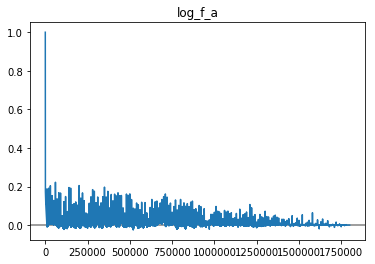

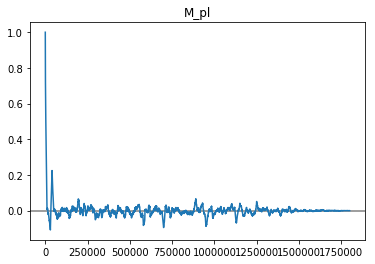

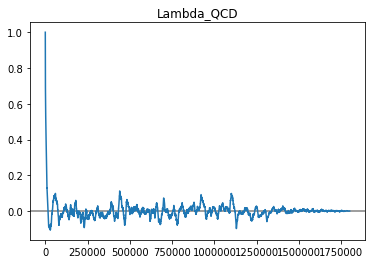

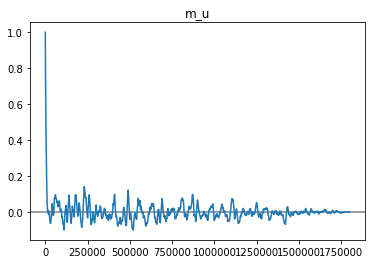

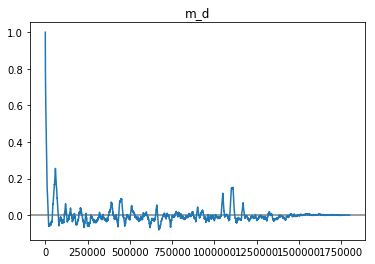

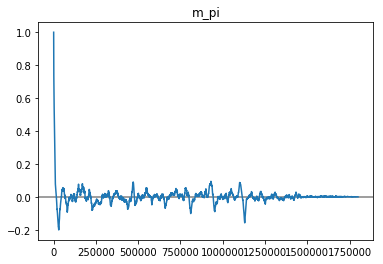

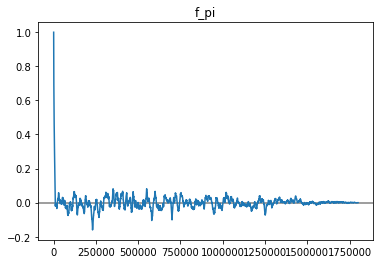

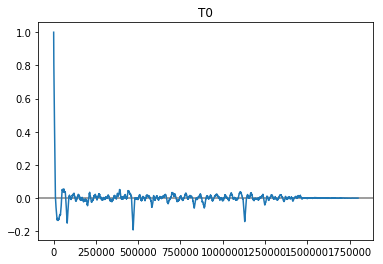

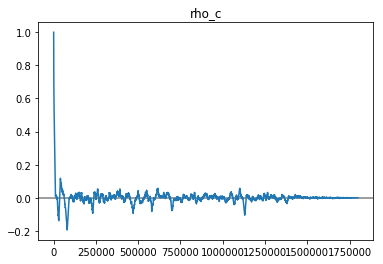

In [4]:
s = df["samples"]
chain = s.reshape((-1, parameter_estimation_anthropic.ndim))
#plt.plot(chain[:, -1])
fn = emcee.autocorr.function(chain)

for i, name in enumerate(parameter_estimation_anthropic.parameter_names):
    plt.axhline(0, color="grey")
    plt.plot(fn[:, i])
    plt.title(name)
    plt.show()

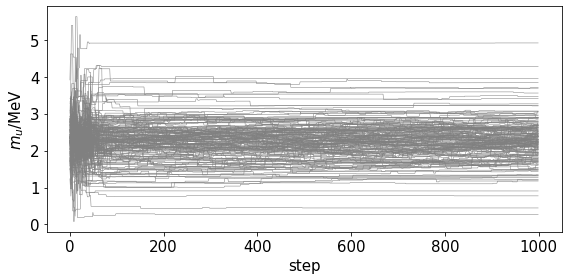

In [3]:
plt.figure(figsize=(8, 4))
m_u_chains = df["samples"]
for i in range(m_u_chains.shape[0]):
    plt.plot(m_u_chains[i, :1000, 3] / 1e6, linewidth=0.5, color="grey")
plt.ylabel(r"$m_u / \mathrm{MeV}$", fontsize=15)
plt.xlabel("step", fontsize=15)
ax = plt.gca()
ax.tick_params(labelsize=15)
#plt.xticks([0, samples.shape[0]], ["0", str(samples.shape[0])])
plt.tight_layout()
plt.savefig(config.plot_path + "/chain.pdf")

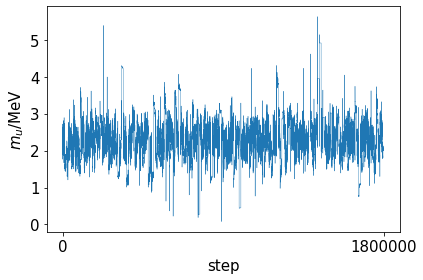

([<matplotlib.axis.XTick at 0x7f622589f9b0>,
 <a list of 2 Text xticklabel objects>)

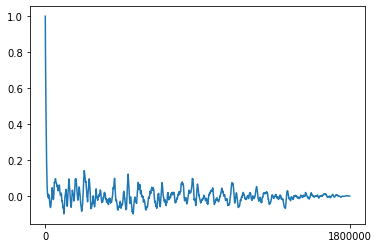

In [14]:
fn = emcee.autocorr.function(samples[:, 3])
plt.plot(fn)
plt.xticks([0, samples.shape[0]], ["0", str(samples.shape[0])])

In [17]:
df["samples"].shape

(180, 10000, 9)